In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import date
from datetime import timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

**Data Cleaning and EDA**

In [2]:
original_df=pd.read_csv("2017_Yellow_Taxi_Trip_Data.csv")

In [3]:
df = original_df.copy()

In [4]:
# converting tpep_pickup_datetime and tpep_dropoff_datetime to datetime formate
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

In [5]:
# Adding a duration column
df['duration'] = ((df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()/60.0)
df.head(3)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,14.066667
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,26.500000
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.200000


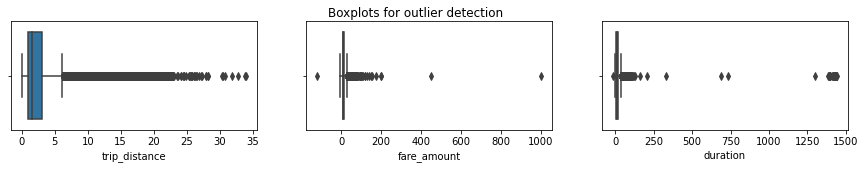

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 2))
fig.suptitle('Boxplots for outlier detection')
sns.boxplot(ax=axes[0], x=df['trip_distance'])
sns.boxplot(ax=axes[1], x=df['fare_amount'])
sns.boxplot(ax=axes[2], x=df['duration'])
plt.show()
#notice there are trip distance equaling 0 likely due to rounding and fareamounts in the negative

In [7]:
# correcting for fare_amount < 0
df.loc[df['fare_amount']< 0, 'fare_amount'] = 0

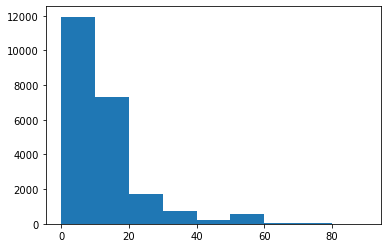

In [8]:
plt.hist(x=df['fare_amount'],bins=range(0,100,10))
plt.show()

In [9]:
#based on the histogram above the max amount is around 60 with a few outliers exceeding that
#impute outliers
def impute_outliers(col,factor):
    df.loc[df[col] < 0, col] = 0
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    upper_threshold = q3 + (factor * iqr)
    print(col)
    print('q3:', q3)
    print('upper_threshold:', upper_threshold)
    df.loc[df[col] > upper_threshold, col] = upper_threshold
    print(df[col].describe())
   

In [10]:
impute_outliers('fare_amount',6)

fare_amount
q3: 14.5
upper_threshold: 62.5
count    22699.000000
mean        12.897913
std         10.541137
min          0.000000
25%          6.500000
50%          9.500000
75%         14.500000
max         62.500000
Name: fare_amount, dtype: float64


In [11]:
df['duration'].describe()

count    22699.000000
mean        17.013777
std         61.996482
min        -16.983333
25%          6.650000
50%         11.183333
75%         18.383333
max       1439.550000
Name: duration, dtype: float64

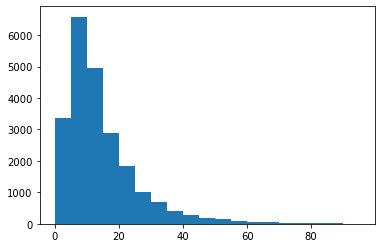

In [12]:
plt.hist(x=df['duration'],bins=range(0,100,5))
plt.show()

In [13]:
#from the histogram above the max is between 60-80
impute_outliers('duration', 6)

duration
q3: 18.383333333333333
upper_threshold: 88.78333333333333
count    22699.000000
mean        14.460555
std         11.947043
min          0.000000
25%          6.650000
50%         11.183333
75%         18.383333
max         88.783333
Name: duration, dtype: float64


In [14]:
df['pickup_dropoff'] = df['PULocationID'].astype(str) + ' ' + df['DOLocationID'].astype(str)
grouped = df.groupby('pickup_dropoff')['trip_distance'].mean().reset_index()
grouped.rename(columns={'trip_distance': 'mean_distance'}, inplace=True)
df = df.join(grouped.set_index('pickup_dropoff'), on='pickup_dropoff')

In [15]:
grouped = df.groupby('pickup_dropoff')['duration'].mean().reset_index()
grouped.rename(columns={'duration': 'mean_duration'}, inplace=True)
df = df.join(grouped.set_index('pickup_dropoff'), on='pickup_dropoff')

In [16]:
df['day'] = df['tpep_pickup_datetime'].dt.day_name().str.lower()
df['month'] = df['tpep_pickup_datetime'].dt.strftime('%b').str.lower()
df['rush_hour'] = df['tpep_pickup_datetime'].dt.hour

In [17]:
# factor in rush hour for fare calculations
df.loc[df['day'].isin(['saturday', 'sunday']), 'rush_hour'] = 0
def rush_hourizer(hour):
    if 6 <= hour['rush_hour'] < 10:
        val = 1
    elif 16 <= hour['rush_hour'] < 20:
        val = 1
    else:
        val = 0
    return val
df.loc[(df.day != 'saturday') & (df.day != 'sunday'), 'rush_hour'] = df.apply(rush_hourizer, axis=1)
df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,tolls_amount,improvement_surcharge,total_amount,duration,pickup_dropoff,mean_distance,mean_duration,day,month,rush_hour
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,...,0.0,0.3,16.56,14.066667,100 231,3.521667,22.847222,saturday,mar,0
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,...,0.0,0.3,20.80,26.500000,186 43,3.108889,24.470370,tuesday,apr,0
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,...,0.0,0.3,8.75,7.200000,262 236,0.881429,7.250000,friday,dec,1
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,...,0.0,0.3,27.69,30.250000,188 97,3.700000,30.250000,sunday,may,0
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,...,0.0,0.3,17.80,16.716667,4 112,4.435000,14.616667,saturday,apr,0


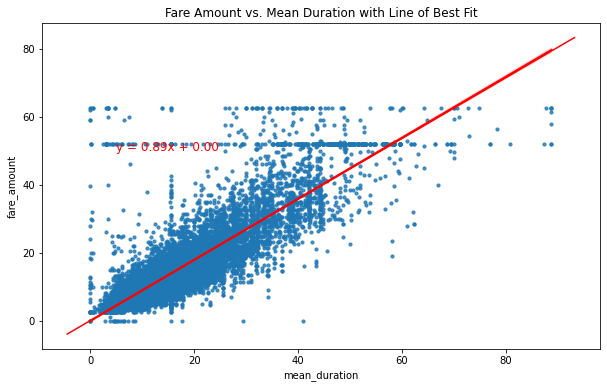

In [23]:
# determining regression line equation setting the y-intercept to 0, however if there is a min charge then that can be replaced for 0
from scipy.optimize import minimize

def objective(params, x, y):
    slope, intercept = params
    predictions = slope * x + intercept
    return np.sum((y - predictions) ** 2)

initial_params = [1, 0]

bounds = [(None, None), (0, None)]

result = minimize(objective, initial_params, args=(df['mean_duration'], df['fare_amount']), bounds=bounds)

slope, intercept = result.x

plt.figure(figsize=(10, 6))

sns.regplot(data=df, x='mean_duration', y='fare_amount', scatter_kws={"s": 10}, line_kws={"color": "red"})

plt.title("Fare Amount vs. Mean Duration with Line of Best Fit")

x_vals = np.array(plt.gca().get_xlim())
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color="red")

plt.text(5, 50, f'y = {slope:.2f}x + {intercept:.2f}', color="red", fontsize=12)

plt.show()

the reason for the line of point at 63 is due to the maximum we have enforced
the reason for the line around 52 is due to the standard fare for trip to JFK airport

to determine regression the only features we will consider are: passenger count, mean distance, mean duration and rush hour flag

In [28]:
df2 = df[['VendorID','passenger_count','fare_amount','mean_distance','mean_duration','rush_hour']]


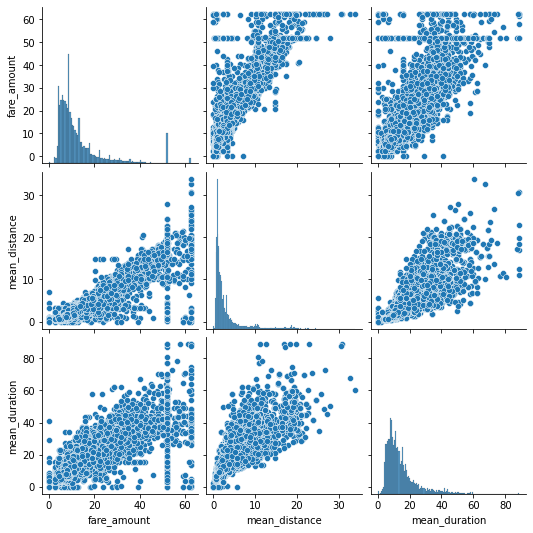

In [30]:
#making a pairplot to understand relationships
sns.pairplot(df2[['fare_amount','mean_distance','mean_duration']])

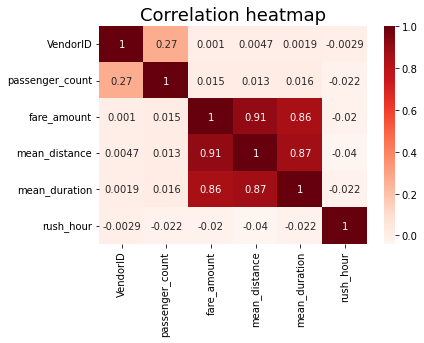

In [31]:
sns.heatmap(df2.corr(method='pearson'), annot=True, cmap='Reds')
plt.title('Correlation heatmap',
          fontsize=18)
plt.show()

In [32]:
x = df2.drop(columns=['fare_amount'])
y = df2[['fare_amount']]


In [33]:
x['VendorID'] = x['VendorID'].astype(str)
x = pd.get_dummies(x, drop_first=True)

,passenger_count,mean_distance,mean_duration,rush_hour,VendorID_2
0,6,3.521667,22.847222,0,1
1,1,3.108889,24.470370,0,0
2,1,0.881429,7.250000,1,0
3,1,3.700000,30.250000,0,1
4,1,4.435000,14.616667,0,1


In [34]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [35]:
#scale data:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [36]:
lr=LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
#evaluating the model:
r_sq = lr.score(X_train_scaled, y_train)
print('Coefficient of determination:', r_sq)
y_pred_train = lr.predict(X_train_scaled)
print('R^2:', r2_score(y_train, y_pred_train))
print('MAE:', mean_absolute_error(y_train, y_pred_train))
print('MSE:', mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(mean_squared_error(y_train, y_pred_train)))

Coefficient of determination: 0.8398434585044773
R^2: 0.8398434585044773
MAE: 2.186666416775414
MSE: 17.88973296349268
RMSE: 4.229625629236313


In [38]:
#working on test data
X_test_scaled = scaler.transform(X_test)
r_sq_test = lr.score(X_test_scaled, y_test)
print('Coefficient of determination:', r_sq_test)
y_pred_test = lr.predict(X_test_scaled)
print('R^2:', r2_score(y_test, y_pred_test))
print('MAE:', mean_absolute_error(y_test,y_pred_test))
print('MSE:', mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))

Coefficient of determination: 0.8682583641795454
R^2: 0.8682583641795454
MAE: 2.1336549840593864
MSE: 14.326454156998944
RMSE: 3.785030271609323


In [39]:
results = pd.DataFrame(data={'actual': y_test['fare_amount'],
                             'predicted': y_pred_test.ravel()})
results['residual'] = results['actual'] - results['predicted']
results.head()

,actual,predicted,residual
5818,14.0,12.356503,1.643497
18134,28.0,16.314595,11.685405
4655,5.5,6.726789,-1.226789
7378,15.5,16.227206,-0.727206
13914,9.5,10.536408,-1.036408


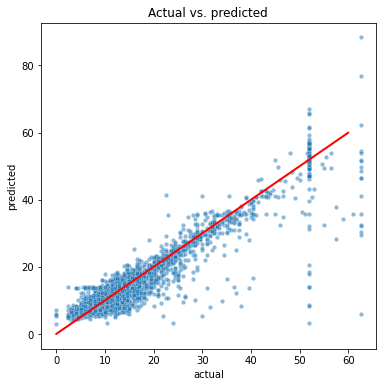

In [40]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.set(style='whitegrid')
sns.scatterplot(x='actual',
                y='predicted',
                data=results,
                s=20,
                alpha=0.5,
                ax=ax
)
# Draw an x=y line to show what the results would be if the model were perfect
plt.plot([0,60], [0,60], c='red', linewidth=2)
plt.title('Actual vs. predicted');

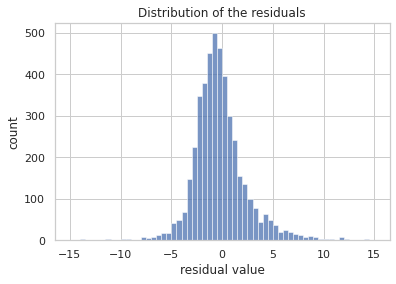

In [41]:
sns.histplot(results['residual'], bins=np.arange(-15,15.5,0.5))
plt.title('Distribution of the residuals')
plt.xlabel('residual value')
plt.ylabel('count');

In [42]:
results['residual'].mean()

-0.015442621528680575

In [44]:
coefficients = pd.DataFrame(lr.coef_, columns=x.columns)
coefficients

,passenger_count,mean_distance,mean_duration,rush_hour,VendorID_2
0,0.030825,7.133867,2.812115,0.110233,-0.054373


In [46]:
print(X_train['mean_distance'].std())
print(7.133867 / X_train['mean_distance'].std())

3.574812975256415
1.9955916713344426
